# Quantum Walk

Quantum walks are quantum analogs of classical random walks. In contrast to the classical random walk, where the walker occupies definite states and the randomness arises due to stochastic transitions between states, in quantum walks randomness arises through various quatum mechanisms such as superpositions, unitary evolutions, quantum interference, etc.

# Our Problem

Here we want to implement a quantum walk in Classiq for the following graph:

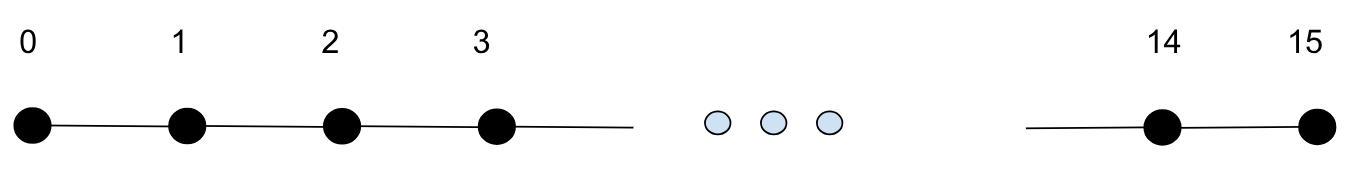

Which we can see is a straight line with 16 nodes.

The probability to go to each adjacent node is equal and 50% if the walker is in the middle nodes (1-14), and 100% if it's in one of the far left or far right nodes (0 or 15).

# Coding

We easily import our modules from classiq library:

In [3]:
from classiq import *

Here we specify the size of our circuit.

The size is calculated as the log2 of the number of node, which here will be 4:

In [6]:
size = 4

## Diffuser

And now we prepare our states, and define a "diffuser operator" which acts like a Grover diffuser operator which amplifies the probabilities of adjacent nodes:

In [7]:
@qfunc
def prep_minus(x: QBit):  # preparing the |-> state
  X(x)
  H(x)

@qfunc
def diffuser(x: QNum, aux: Output[QNum]):  # the condition of the diffuser
  aux ^= (x != 0)

@qfunc
def zero_diffuser(x: QNum):  # applying the zero diffuser and reversing it (like Grover algo) with within_apply
  aux = QNum('aux')
  allocate(1, aux)
  within_apply(compute=lambda: prep_minus(aux), action=lambda: diffuser)

## Coin and Shift

Now, we have to implement the two stages/structures of a quantum walk, a "Coin operator", and a "Shift operator".

### Coin operator

The Coin operator is analogous to flipping a coin, but quantumly; and it determines the walker's movement probabilities to either go right or left (in this example).

It assigns amplitudes to move left or right to the walker, and transforms its state.

Therefore here we must first assign amplitudes or probabilities whether the walker should go right or left, and then apply a transform (with control) to the walker:

In [13]:
def C_iter(i: int, vertices: QNum, adjacents: QNum):  # the Coin operator's iteration cycle
  probs = [0] * (2 ** size)  # creating a list of probabilities for each node

  if i == 0:
    probs[i+1] = 1.0  # if the walker is at node 0 (first node), it can only go right, therefore setting the probability of the right node (1) to 100%

  elif i == 15:
    probs[i-1] = 1.0  # if the walker is at node 15 (last node), it can only go left, therefore setting the probability of the left node (14) to 100%

  else:               # the other nodes in the middle have equal probabilities to go either right or left (50%)
    probs[i+1] = 0.5
    probs[i-1] = 0.5

  print(f'State = {i}, prob vec = {probs}')  # checking out the probs list for each state

  # we now apply a controlled transform (controlled zero diffuser) onto the walker's state based on the probabilities
  control(ctrl= vertices==i,
          operand= lambda: within_apply(compute= lambda: inplace_prepare_state(probabilities=probs, bound=0.01, target=adjacents),
                                        action= lambda: zero_diffuser(adjacents))
          )

@qfunc
def C_operator(vertices: QNum, adjacents: QNum):  # the Coin operator which will repeat the Coin iteration as many times as the number of nodes
  for i in range(2**size):
    C_iter(i, vertices, adjacents)

### Shift operator

We implemented the Coin operator, now we must implement the Shift operator, which executes the walker's movement by bitwise-swapping the states between nodes, based on the Coin operation's amplitudes.

Important to note that like we said before, quantum walks are affected by some quantum mechanisms which here can be occured:

In [10]:
@qfunc
def edge(res: Output[QBit], vertices: QNum, adjacents: QNum):  # an edge-checking function to see which nodes are adjacent
  res |= (((vertices + adjacents) % 2) == 1)  # this condition is general to most quantum walks, including this problem

@qfunc
def bit_swap(x: QArray[QBit], y: QArray[QBit]):  # the bitwise swap operation applies repeatedly to swap the nodes, based on the probabilities from the Coin operation
  repeat(count= x.len,
         iteration= lambda i: SWAP(x[i], y[i]))

@qfunc
def S_operator(vertices: QNum, adjacents: QNum):  # the Shift operator which first does the edge-checking, then applies the bit-swap if the nodes are adjacent
  res = QNum('res')
  edge(res, vertices, adjacents)
  control(ctrl= res==1,
          operand= lambda: bit_swap(vertices, adjacents))

## Putting it all together

We now have implemented all sections of a quantum walk for this problem.

And now, we implement all of it together:

In [11]:
@qfunc
def main(vertices: Output[QNum], adjacents: Output[QNum]):
  allocate(size, vertices)
  hadamard_transform(vertices)  # equal superposition of vertices
  allocate(size, adjacents)

  C_operator(vertices, adjacents)  # applying the Coin operation
  S_operator(vertices, adjacents)  # applying the Shift operation

Finally we create our model, and synthesise and show the circuit (we can also see the probability vectors of each state as we coded before):

In [14]:
qmodel = create_model(main)
qprogram = synthesize(qmodel)
show(qprogram)

State = 0, prob vec = [0, 1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State = 1, prob vec = [0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State = 2, prob vec = [0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State = 3, prob vec = [0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State = 4, prob vec = [0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State = 5, prob vec = [0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State = 6, prob vec = [0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0]
State = 7, prob vec = [0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0]
State = 8, prob vec = [0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0]
State = 9, prob vec = [0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0]
State = 10, prob vec = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0]
State = 11, prob vec = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0]
State = 12, prob vec = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0]
State = 13, prob vec = [

# Circuit and Summary

Here is our circuit:

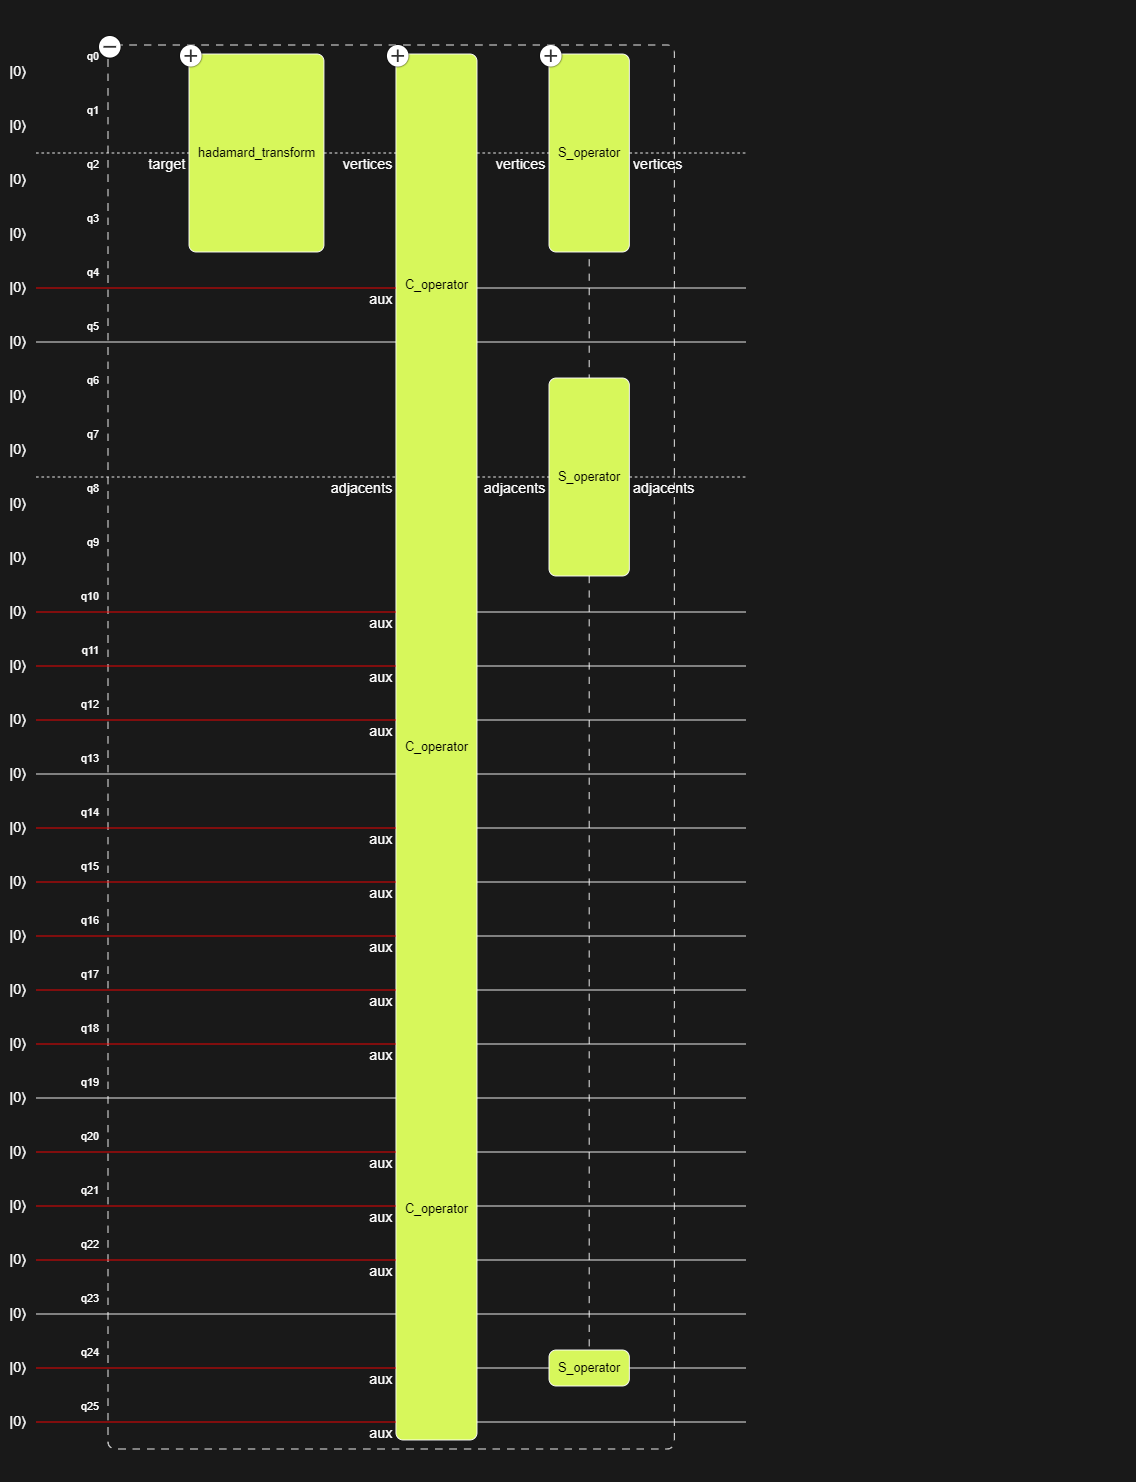

As we can see, the circuit first applies an equal superposition on the vertices qubits with hadamard transforms.

Then it applies the coin operation to the vertices and aux qubits. If we open the C_operator block, we can see 16 (the number of nodes) state-preparation and zero-diffuser operations applied to create each node and their respective probabilites, and store them in auxiliary qubits:

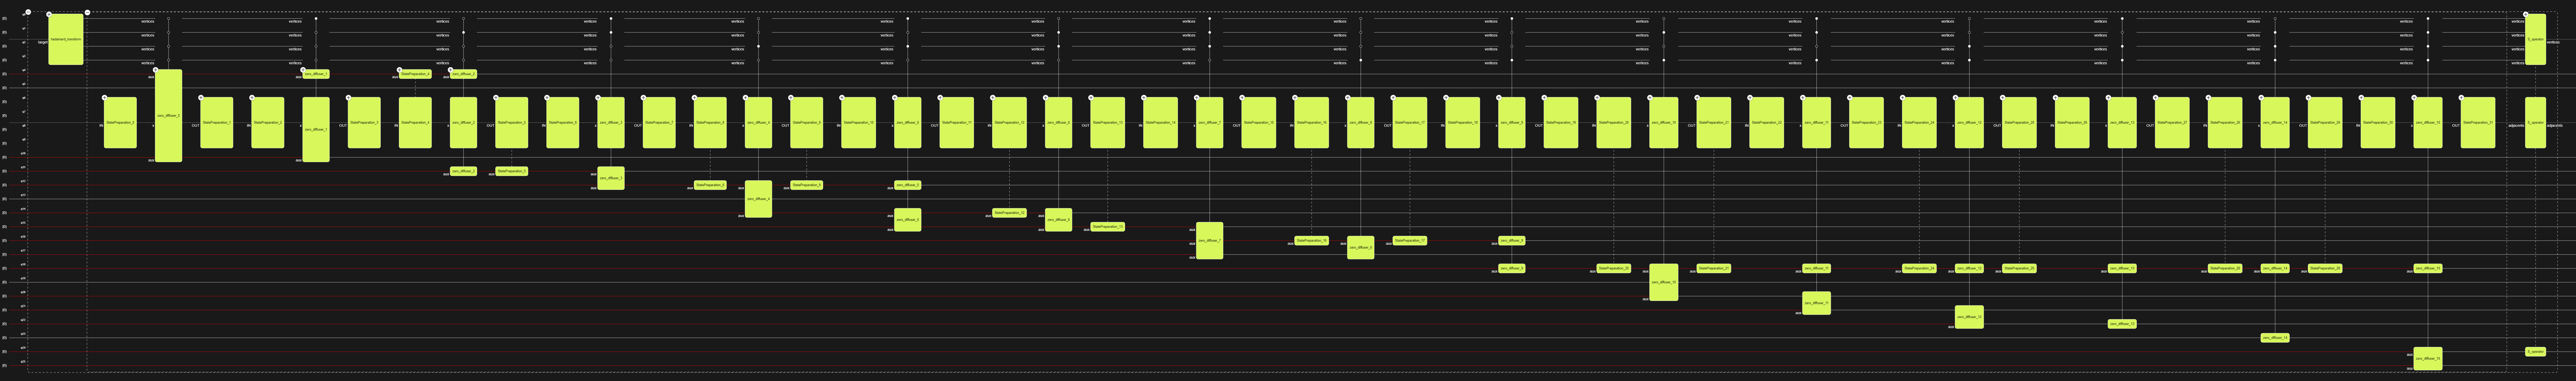

After the C_operator, we see the S_operator block which is our Shift operation.

Opening the block shows us the edge-checking being applied on vertices and adjacents, using an auxiliary qubit to do the checking; and the shifting being applied on vertices and their adjacents to swap the walker's state based on the probs given from the Coin operation:

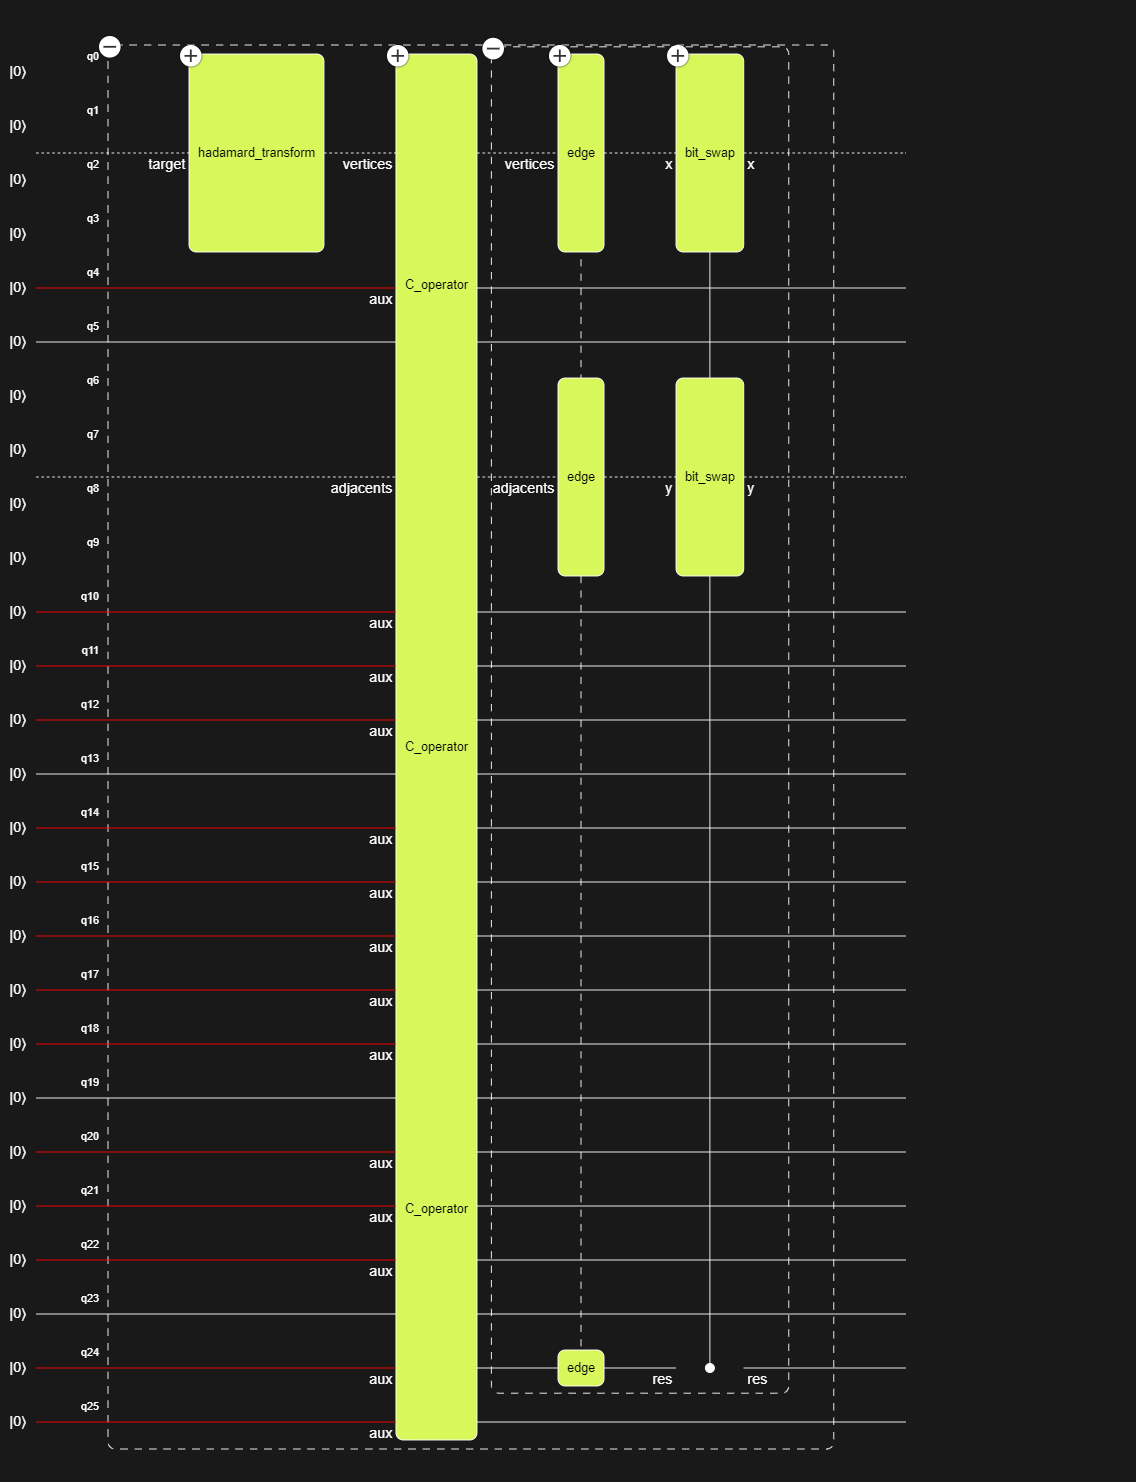

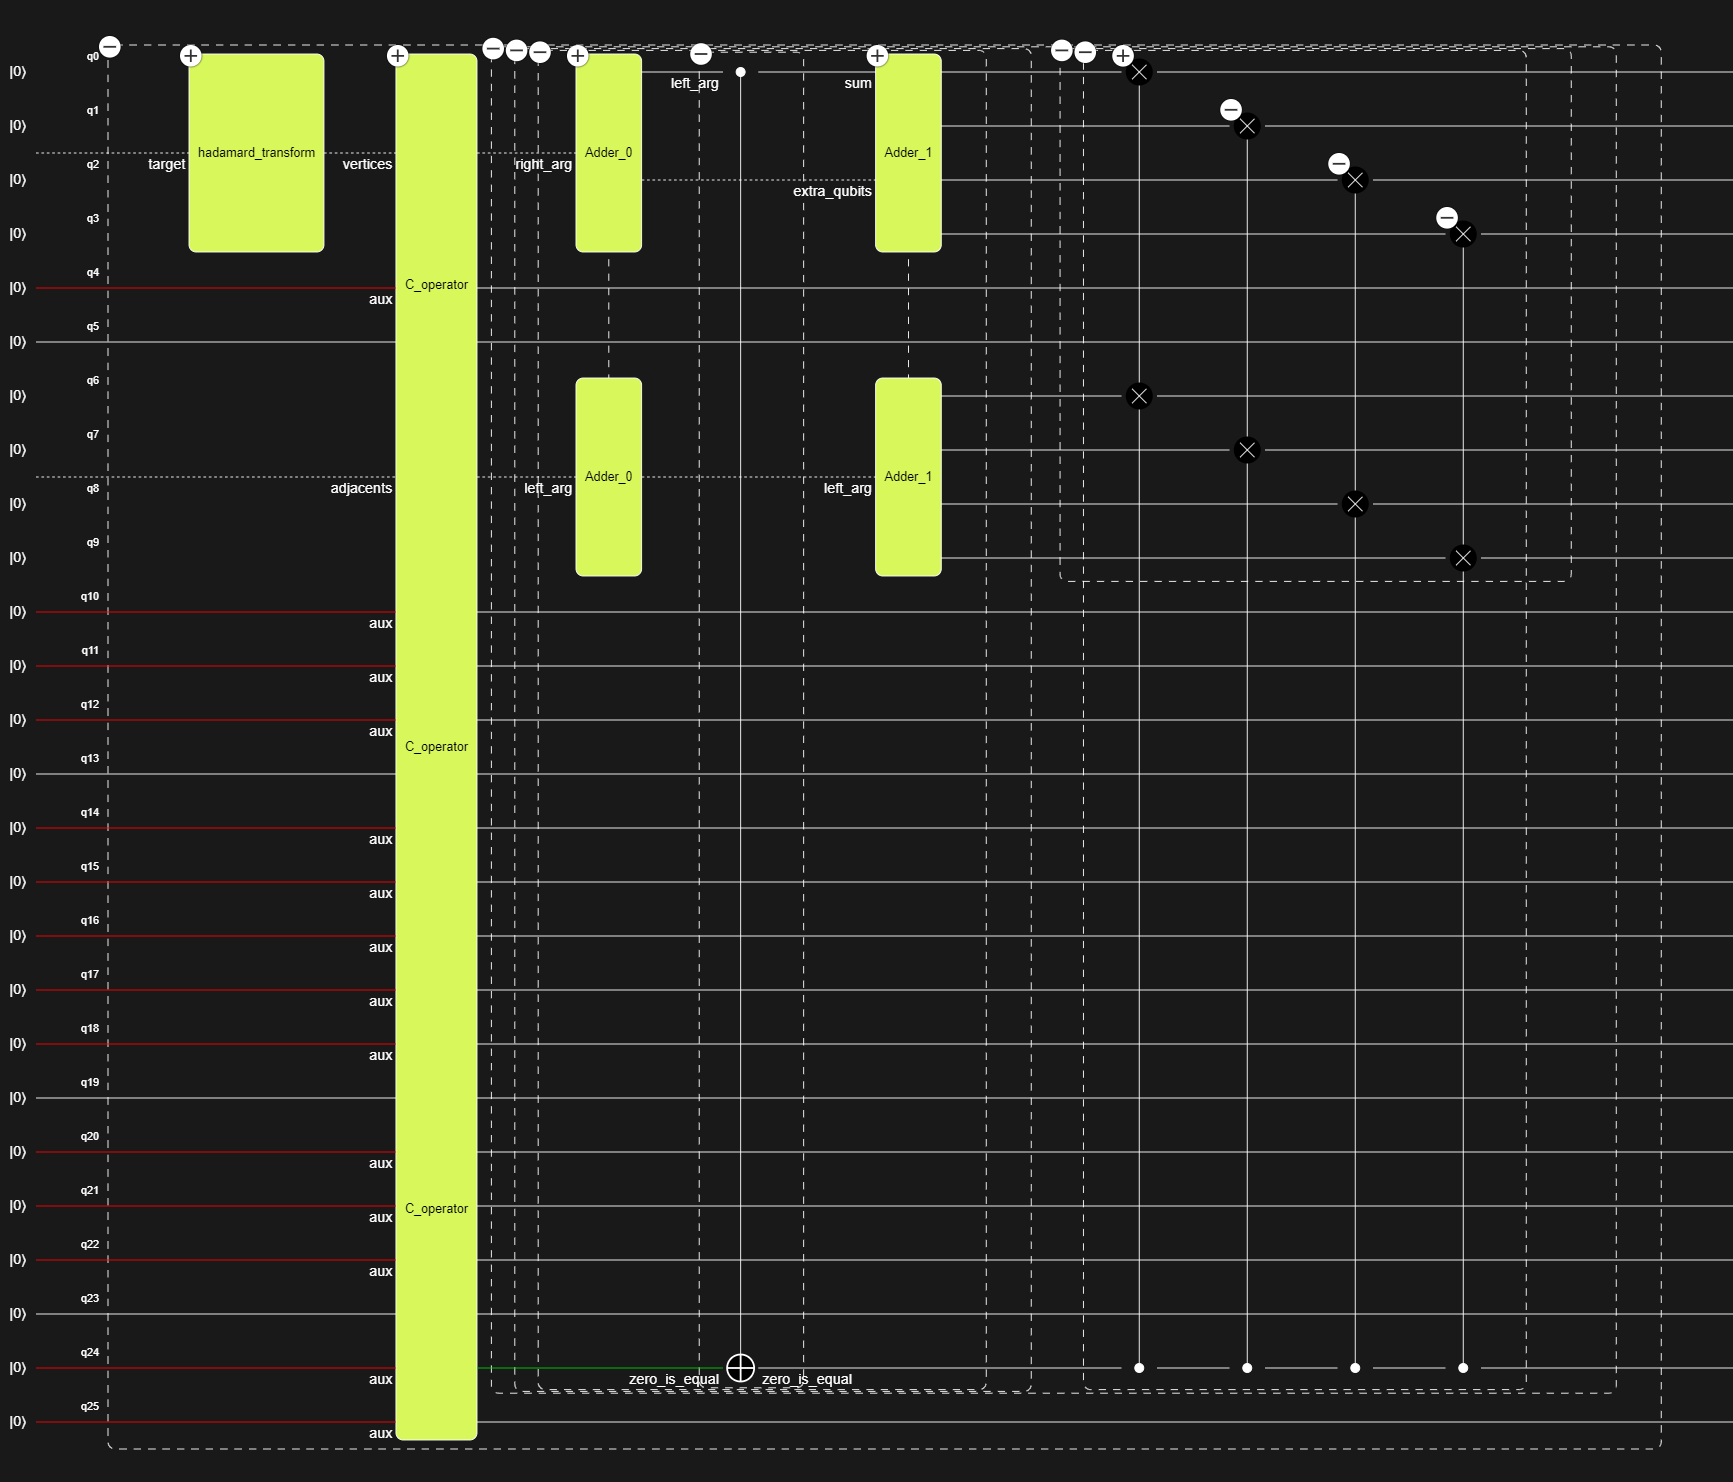

In this way we saw we can implement a quantum walk for this problem.

In short then, a quantum walk has these key operations:
- Hadamard transform of vertices
- Coin operation (inside which is state preparation + diffuser like Grover algorithm)
- Shift operation which swaps adjacent nodes together based on probabilites from the Coin operation